In [1]:
import os
import sys
home_dir = "../../"
module_path = os.path.abspath(os.path.join(home_dir))
if module_path not in sys.path:
    sys.path.append(module_path)

import random
import numpy as np
import pandas as pd
from models.aa_common.performance_metrics import *

In [47]:
task = "patho_and_likelypatho" 
negative_cls = "Neutral"
positive_cls = "Likely-pathogenic" # Pathogenic, Likely-pathogenic
n_samples = 1000
# model_root_and_name_tuple_list = [("", "random_classifier"), ("", "conservation")]
model_root_and_name_tuple_list = [("dbnsfp", "sift"), ("dbnsfp", "polyphen2_HVAR"), ("dbnsfp", "cadd"), ("dbnsfp", "mvp"), ("dbnsfp", "metarnn"), ("dbnsfp", "revel"),
                                  ("sequnet_dunham", "sequnet"), ("vespa_marquet", "vespa"),
                                  ("tape_rao", "unirep"), ("tape_rao", "protbert"), 
                                  ("esm_rives", "esm1b_t33_650M_UR50S"), ("esm_rives", "esm1v_t33_650M_UR90S"), ("esm_rives", "esm2_t33_650M_UR50D"),
                                  ("bioembeddings_dallago", "plus_rnn"), 
                                  ("bioembeddings_dallago", "prottrans_bert_bfd"), ("bioembeddings_dallago", "prottrans_albert_bfd"),
                                  ("bioembeddings_dallago", "prottrans_xlnet_uniref100"), 
                                  ("bioembeddings_dallago", "prottrans_t5_bfd"), ("bioembeddings_dallago", "prottrans_t5_uniref50"), ("bioembeddings_dallago", "prottrans_t5_xl_u50"),
                                  ("dbnsfp", "integrated_fitCons"), ("dbnsfp", "phyloP17way_primate"), ("dbnsfp", "phastCons17way_primate"), ("dbnsfp", "bStatistic"),
                                  ("", "random_classifier"), ]

# by default, we consider larger means positive class (here pathogenic or likely-pathogenic), but the following models have specific opposite meaning
models_smaller_means_damaging = ["sequnet", "sift"]

metrics = ["KS-statistic", "KS-pvalue", "AUC-ROC", "AUC-PR", "F1-max", "Th-max", "Precision", "Recall", "Accuracy", "Balanced-accuracy", "MCC", "Missing values (%)"]

In [48]:
columns = ['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
            'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 
            'sift_pred', 'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred',
            'metarnn_pred', 'revel_pred', 'sequnet_pred', 'vespa_pred',
            'unirep_pred', 'protbert_pred', 'esm1b_t33_650M_UR50S_pred',
            'esm1v_t33_650M_UR90S_pred', 'esm2_t33_650M_UR50D_pred',
            'plus_rnn_pred', 'prottrans_bert_bfd_pred', 'prottrans_albert_bfd_pred',
            'prottrans_xlnet_uniref100_pred', 'prottrans_t5_bfd_pred',
            'prottrans_t5_uniref50_pred', 'prottrans_t5_xl_u50_pred',
            'integrated_fitCons_pred', 'phyloP17way_primate_pred',
            'phastCons17way_primate_pred', 'bStatistic_pred',
            'n_methods_having_preds']

patho_and_likelypatho_result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/{task}_analysis.csv", sep="\t")
patho_and_likelypatho_result_df = patho_and_likelypatho_result_df.rename(columns={"clinvar_id":"id"})
patho_and_likelypatho_result_df = patho_and_likelypatho_result_df[columns]
print(patho_and_likelypatho_result_df.shape)
print(patho_and_likelypatho_result_df.columns)


popu_freq_result_df = pd.read_csv(home_dir+f"models/aa_common/merged_predictions/popu_freq_analysis.csv", sep="\t")
popu_freq_result_df = popu_freq_result_df[(popu_freq_result_df["class"]=="Common") | (popu_freq_result_df["class"]=="Rare")]
popu_freq_result_df["class"] = negative_cls
popu_freq_result_df = popu_freq_result_df.rename(columns={"snp_id":"id"})
popu_freq_result_df = popu_freq_result_df[columns]


patho_and_likelypatho_result_df_unique_prots_list = patho_and_likelypatho_result_df["prot_acc_version"].unique()
popu_freq_result_df = popu_freq_result_df[popu_freq_result_df["prot_acc_version"].isin(patho_and_likelypatho_result_df_unique_prots_list)] # variants must be of same proteins/genes from patho_and_likelypatho

print(popu_freq_result_df.shape)
print(popu_freq_result_df.columns)

result_df = pd.concat([popu_freq_result_df, patho_and_likelypatho_result_df])
result_df = result_df[(result_df['class']==negative_cls) | (result_df['class']==positive_cls)]
print(result_df["class"].value_counts())

# only keeping rows that have at least 4 supervised prediction scores.
# the empty rows are populated with the median values of that colum
filtered_result_df = result_df[result_df["n_methods_having_preds"]>=4]
print(filtered_result_df["class"].value_counts())

missing_value_percentage_dict = {}
for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        missing_value_percentage_dict[model_pred_col] = 0.0
        continue
    # model_pred_col = "esm1b_t33_650M_UR50S_pred"
    median = filtered_result_df[model_pred_col].median()
    nan_value_rows = filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col])].shape[0]
    missing_value_percentage_dict[model_pred_col] = 100*(nan_value_rows / result_df.shape[0])
    print("\tnan value rows:", nan_value_rows)
    if nan_value_rows>0:
        filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col]), model_pred_col] = median
    print("\tafter populating nan value rows with median:", filtered_result_df.loc[pd.isna(filtered_result_df[model_pred_col])].shape)
    # break
result_df = filtered_result_df
result_df["class"].value_counts()

(6476, 35)
Index(['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred', 'mvp_pred', 'metarnn_pred',
       'revel_pred', 'sequnet_pred', 'vespa_pred', 'unirep_pred',
       'protbert_pred', 'esm1b_t33_650M_UR50S_pred',
       'esm1v_t33_650M_UR90S_pred', 'esm2_t33_650M_UR50D_pred',
       'plus_rnn_pred', 'prottrans_bert_bfd_pred', 'prottrans_albert_bfd_pred',
       'prottrans_xlnet_uniref100_pred', 'prottrans_t5_bfd_pred',
       'prottrans_t5_uniref50_pred', 'prottrans_t5_xl_u50_pred',
       'integrated_fitCons_pred', 'phyloP17way_primate_pred',
       'phastCons17way_primate_pred', 'bStatistic_pred',
       'n_methods_having_preds'],
      dtype='object')
(3639, 35)
Index(['id', 'chrom_acc_version', 'chrom_pos', 'ref_allele', 'alt_allele',
       'prot_acc_version', 'prot_pos', 'wt', 'mut', 'class', 'sift_pred',
       'polyphen2_HVAR_pred', 'cadd_pred

Likely-pathogenic    3699
Neutral              3153
Name: class, dtype: int64

### Computing all methods performance metrics

In [49]:
def get_non_nan_df(df, col_name):
    non_nan_df = df[~pd.isna(df[col_name])]  # taking df for only non-NAN values
    
    n_missing = df[pd.isna(df[col_name])].shape[0] 
    total = df.shape[0]
    missing_values_percentage = (n_missing / total) * 100
    print(f"\tMissing values: 100*{n_missing}/{total}={missing_values_percentage}")
    
    return non_nan_df, missing_values_percentage

def calibrate_prediction_scores_direction(df, model_name):
    if model_name in models_smaller_means_damaging:
        df['pred'] = df['pred'].multiply(-1)
    
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(df)
    if not larger_means_positive_class:
        df['pred'] = df['pred'].multiply(-1)
    
    return df, auc_roc_score

def sample_positive_and_negative_data_points(df):
    df = df.copy(deep=True)
    positive_cls_result_df = df[df["class"]==positive_cls]
    negative_cls_result_df = df[df["class"]==negative_cls]
    
    positive_cls_result_df["class_numeric"] = 1
    negative_cls_result_df["class_numeric"] = 0

    positive_cls_unique_prots_list = positive_cls_result_df["prot_acc_version"].unique()
    negative_cls_result_df = negative_cls_result_df[negative_cls_result_df["prot_acc_version"].isin(positive_cls_unique_prots_list)] # variants must be of same proteins/genes from patho_and_likelypatho
    print(f"\t{positive_cls}(+ve): {positive_cls_result_df.shape}, {negative_cls}(-ve): {negative_cls_result_df.shape}")

    positive_cls_result_df = positive_cls_result_df.sample(n=n_samples)
    negative_cls_result_df = negative_cls_result_df.sample(n=n_samples)
    
    result_df = pd.concat([positive_cls_result_df, negative_cls_result_df])
    return result_df

def get_pathogenic_analysis_threshold(model_name):
    patho_performance_metrics_df = pd.read_csv(home_dir+f"models/aa_common/performance_analysis/{task}_Pathogenic_vs_{negative_cls}_analysis.csv", sep="\t")
    patho_th_max = patho_performance_metrics_df[patho_performance_metrics_df["Models\\Metrics"]==model_name]["Th-max"].values[1]
    patho_th_max = patho_th_max.split('(')[0]
    patho_th_max = float(patho_th_max)
    print(f"\tComputed th from pathogenic-analysis: {patho_th_max}")
    return patho_th_max


In [50]:
performance_scores_dict = {}

for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    print(model_name)
    model_pred_col = model_name + "_pred"

    performance_scores = []

    for i_run in range(10): #10 runs
        sampled_result_df = sample_positive_and_negative_data_points(result_df)
            
        if model_name=="random_classifier": sampled_result_df[model_pred_col] = [random.uniform(0, 1) for i in range(sampled_result_df.shape[0])]
        
        sampled_result_df["pred"]=(sampled_result_df[model_pred_col]-sampled_result_df[model_pred_col].min())/(sampled_result_df[model_pred_col].max()-sampled_result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]
        
        non_nan_result_df, missing_values_percentage = get_non_nan_df(sampled_result_df, model_pred_col)
        
        non_nan_result_df, auc_roc_score =  calibrate_prediction_scores_direction(non_nan_result_df, model_name)
        
        ks_statistic, ks_pvalue = get_KS_test_score(non_nan_result_df)
        auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
        f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)

        if positive_cls=="Likely-pathogenic": th_max =  get_pathogenic_analysis_threshold(model_name)
        
        precision = get_precision_score(non_nan_result_df, th_max)
        recall = get_recall_score(non_nan_result_df, th_max)
        accuracy = get_accuracy_score(non_nan_result_df, th_max)
        balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
        mcc = get_matthews_corrcoef(non_nan_result_df, th_max)
        
        performance_scores.append([ks_statistic, ks_pvalue, auc_roc_score, auc_pr_score, f1_max, th_max, precision, recall, accuracy, balanced_accuracy, mcc, missing_value_percentage_dict[model_pred_col]])
        print()
            
    performance_scores_dict[model_name] = performance_scores
# performance_scores_dict

sift
	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.849
	KS-test score. statistic: 0.565, p-value: 0.000
	AUC-PR: 0.846
	Best F1-Score: 0.788 at threshold: -0.034
	Computed th from pathogenic-analysis: -0.027
	Precision score: 0.734 at threshold: -0.027
	Recall score: 0.840 at threshold: -0.027
	Accuracy score: 0.767 at threshold: -0.027
	Balanced accuracy score: 0.767 at threshold: -0.027
	MCC score: 0.541 at threshold: -0.027

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.845
	KS-test score. statistic: 0.553, p-value: 0.000
	AUC-PR: 0.840
	Best F1-Score: 0.789 at threshold: -0.044
	Computed th from pathogenic-analysis: -0.027
	Precision score: 0.733 at threshold: -0.027
	Recall score: 0.838 at threshold: -0.027
	Accuracy score: 0.766 at threshold: -0.027
	Balanced accuracy score: 0.766 at threshold: -0.027
	MCC score: 0.539 at threshold: -0.027

	Likely-pathogenic(+v

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.864
	KS-test score. statistic: 0.579, p-value: 0.000
	AUC-PR: 0.859
	Best F1-Score: 0.804 at threshold: -0.044
	Computed th from pathogenic-analysis: -0.027
	Precision score: 0.750 at threshold: -0.027
	Recall score: 0.853 at threshold: -0.027
	Accuracy score: 0.784 at threshold: -0.027
	Balanced accuracy score: 0.784 at threshold: -0.027
	MCC score: 0.573 at threshold: -0.027

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.872
	KS-test score. statistic: 0.601, p-value: 0.000
	AUC-PR: 0.872
	Best F1-Score: 0.804 at threshold: -0.022
	Computed th from pathogenic-analysis: -0.027
	Precision score: 0.754 at threshold: -0.027
	Recall score: 0.856 at threshold: -0.027
	Accuracy score: 0.788 at threshold: -0.027
	Balanced accuracy score: 0.788 at threshold: -0.027
	MCC score: 0.581 at threshold: -0.027

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/200

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Computed th from pathogenic-analysis: -0.027
	Precision score: 0.730 at threshold: -0.027
	Recall score: 0.834 at threshold: -0.027
	Accuracy score: 0.763 at threshold: -0.027
	Balanced accuracy score: 0.763 at threshold: -0.027
	MCC score: 0.531 at threshold: -0.027

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.845
	KS-test score. statistic: 0.548, p-value: 0.000
	AUC-PR: 0.837
	Best F1-Score: 0.792 at threshold: -0.044
	Computed th from pathogenic-analysis: -0.027
	Precision score: 0.741 at threshold: -0.027
	Recall score: 0.832 at threshold: -0.027
	Accuracy score: 0.770 at threshold: -0.027
	Balanced accuracy score: 0.770 at threshold: -0.027
	MCC score: 0.545 at threshold: -0.027

polyphen2_HVAR
	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.846
	KS-test score. statistic: 0.547, p-value: 0.000
	AUC-PR: 0.828
	Best F1-Score: 0.791 at threshold: 0.365
	Computed th

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.718 at threshold: 0.489
	Recall score: 0.879 at threshold: 0.489
	Accuracy score: 0.766 at threshold: 0.489
	Balanced accuracy score: 0.766 at threshold: 0.489
	MCC score: 0.547 at threshold: 0.489

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.843
	KS-test score. statistic: 0.528, p-value: 0.000
	AUC-PR: 0.827
	Best F1-Score: 0.787 at threshold: 0.404
	Computed th from pathogenic-analysis: 0.489
	Precision score: 0.706 at threshold: 0.489
	Recall score: 0.879 at threshold: 0.489
	Accuracy score: 0.756 at threshold: 0.489
	Balanced accuracy score: 0.756 at threshold: 0.489
	MCC score: 0.529 at threshold: 0.489

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.852
	KS-test score. statistic: 0.550, p-value: 0.000
	AUC-PR: 0.837
	Best F1-Score: 0.792 at threshold: 0.328
	Computed th from pathogenic-analysis: 0.489
	Precision score: 0.713 at threshold: 0.

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.796 at threshold: 0.569
	Balanced accuracy score: 0.796 at threshold: 0.569
	MCC score: 0.596 at threshold: 0.569

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.871
	KS-test score. statistic: 0.609, p-value: 0.000
	AUC-PR: 0.827
	Best F1-Score: 0.823 at threshold: 0.520
	Computed th from pathogenic-analysis: 0.569
	Precision score: 0.759 at threshold: 0.569
	Recall score: 0.885 at threshold: 0.569
	Accuracy score: 0.802 at threshold: 0.569
	Balanced accuracy score: 0.802 at threshold: 0.569
	MCC score: 0.612 at threshold: 0.569

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.865
	KS-test score. statistic: 0.606, p-value: 0.000
	AUC-PR: 0.822
	Best F1-Score: 0.822 at threshold: 0.520
	Computed th from pathogenic-analysis: 0.569
	Precision score: 0.750 at threshold: 0.569
	Recall score: 0.880 at threshold: 0.569
	Accuracy score: 0.793 at threshold: 0.5

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.793 at threshold: 0.569
	MCC score: 0.600 at threshold: 0.569

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.863
	KS-test score. statistic: 0.603, p-value: 0.000
	AUC-PR: 0.815
	Best F1-Score: 0.823 at threshold: 0.515
	Computed th from pathogenic-analysis: 0.569
	Precision score: 0.757 at threshold: 0.569
	Recall score: 0.883 at threshold: 0.569
	Accuracy score: 0.799 at threshold: 0.569
	Balanced accuracy score: 0.799 at threshold: 0.569
	MCC score: 0.608 at threshold: 0.569

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.859
	KS-test score. statistic: 0.595, p-value: 0.000
	AUC-PR: 0.818
	Best F1-Score: 0.815 at threshold: 0.543
	Computed th from pathogenic-analysis: 0.569
	Precision score: 0.757 at threshold: 0.569
	Recall score: 0.865 at threshold: 0.569
	Accuracy score: 0.793 at threshold: 0.569
	Balanced accuracy score: 0.793 at thres

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.295 at threshold: 0.867

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.779
	KS-test score. statistic: 0.568, p-value: 0.000
	AUC-PR: 0.797
	Best F1-Score: 0.764 at threshold: 0.923
	Computed th from pathogenic-analysis: 0.867
	Precision score: 0.604 at threshold: 0.867
	Recall score: 0.817 at threshold: 0.867
	Accuracy score: 0.640 at threshold: 0.867
	Balanced accuracy score: 0.640 at threshold: 0.867
	MCC score: 0.300 at threshold: 0.867

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.785
	KS-test score. statistic: 0.574, p-value: 0.000
	AUC-PR: 0.802
	Best F1-Score: 0.767 at threshold: 0.923
	Computed th from pathogenic-analysis: 0.867
	Precision score: 0.610 at threshold: 0.867
	Recall score: 0.816 at threshold: 0.867
	Accuracy score: 0.647 at threshold: 0.867
	Balanced accuracy score: 0.647 at threshold: 0.867
	MCC score: 0.313 at threshold: 0.867

	

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.782
	KS-test score. statistic: 0.572, p-value: 0.000
	AUC-PR: 0.800
	Best F1-Score: 0.767 at threshold: 0.925
	Computed th from pathogenic-analysis: 0.867
	Precision score: 0.607 at threshold: 0.867
	Recall score: 0.815 at threshold: 0.867
	Accuracy score: 0.644 at threshold: 0.867
	Balanced accuracy score: 0.644 at threshold: 0.867
	MCC score: 0.306 at threshold: 0.867

metarnn
	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.977
	KS-test score. statistic: 0.902, p-value: 0.000
	AUC-PR: 0.961
	Best F1-Score: 0.953 at threshold: 0.224
	Computed th from pathogenic-analysis: 0.291
	Precision score: 0.925 at threshold: 0.291
	Recall score: 0.980 at threshold: 0.291
	Accuracy score: 0.951 at threshold: 0.291
	Balanced accuracy score: 0.951 at threshold: 0.291
	MCC score: 0.903 at threshold: 0.291

	Likely-pathogenic(+ve): (3699, 

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.973
	KS-test score. statistic: 0.896, p-value: 0.000
	AUC-PR: 0.954
	Best F1-Score: 0.950 at threshold: 0.203
	Computed th from pathogenic-analysis: 0.291
	Precision score: 0.921 at threshold: 0.291
	Recall score: 0.975 at threshold: 0.291
	Accuracy score: 0.946 at threshold: 0.291
	Balanced accuracy score: 0.946 at threshold: 0.291
	MCC score: 0.893 at threshold: 0.291

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.975
	KS-test score. statistic: 0.900, p-value: 0.000
	AUC-PR: 0.952
	Best F1-Score: 0.952 at threshold: 0.273
	Computed th from pathogenic-analysis: 0.291
	Precision score: 0.923 at threshold: 0.291
	Recall score: 0.979 at threshold: 0.291
	Accuracy score: 0.949 at threshold: 0.291
	Balanced accuracy score: 0.949 at threshold: 0.291
	MCC score: 0.899 at threshold: 0.291

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.897
	KS-test score. statistic: 0.656, p-value: 0.000
	AUC-PR: 0.881
	Best F1-Score: 0.834 at threshold: 0.456
	Computed th from pathogenic-analysis: 0.397
	Precision score: 0.752 at threshold: 0.397
	Recall score: 0.918 at threshold: 0.397
	Accuracy score: 0.808 at threshold: 0.397
	Balanced accuracy score: 0.808 at threshold: 0.397
	MCC score: 0.631 at threshold: 0.397

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.907
	KS-test score. statistic: 0.662, p-value: 0.000
	AUC-PR: 0.894
	Best F1-Score: 0.841 at threshold: 0.455
	Computed th from pathogenic-analysis: 0.397
	Precision score: 0.759 at threshold: 0.397
	Recall score: 0.934 at threshold: 0.397
	Accuracy score: 0.819 at threshold: 0.397
	Balanced accuracy score: 0.819 at threshold: 0.397
	MCC score: 0.655 at threshold: 0.397

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.898
	KS-test score. statisti

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.895
	KS-test score. statistic: 0.649, p-value: 0.000
	AUC-PR: 0.880
	Best F1-Score: 0.829 at threshold: 0.539
	Computed th from pathogenic-analysis: 0.397
	Precision score: 0.746 at threshold: 0.397
	Recall score: 0.916 at threshold: 0.397
	Accuracy score: 0.802 at threshold: 0.397
	Balanced accuracy score: 0.802 at threshold: 0.397
	MCC score: 0.620 at threshold: 0.397

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.903
	KS-test score. statistic: 0.677, p-value: 0.000
	AUC-PR: 0.895
	Best F1-Score: 0.843 at threshold: 0.535
	Computed th from pathogenic-analysis: 0.397
	Precision score: 0.753 at threshold: 0.397
	Recall score: 0.917 at threshold: 0.397
	Accuracy score: 0.808 at threshold: 0.397
	Balanced accuracy score: 0.808 at threshold: 0.397
	MCC score: 0.632 at threshold: 0.397

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.896
	KS-test score. statisti

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.843 at threshold: 0.040
	Accuracy score: 0.568 at threshold: 0.040
	Balanced accuracy score: 0.568 at threshold: 0.040
	MCC score: 0.163 at threshold: 0.040

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.344
	KS-test score. statistic: 0.271, p-value: 0.000
	AUC-PR: 0.626
	Best F1-Score: 0.679 at threshold: 0.019
	Computed th from pathogenic-analysis: 0.04
	Precision score: 0.551 at threshold: 0.040
	Recall score: 0.854 at threshold: 0.040
	Accuracy score: 0.579 at threshold: 0.040
	Balanced accuracy score: 0.579 at threshold: 0.040
	MCC score: 0.188 at threshold: 0.040

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.363
	KS-test score. statistic: 0.212, p-value: 0.000
	AUC-PR: 0.626
	Best F1-Score: 0.675 at threshold: 0.019
	Computed th from pathogenic-analysis: 0.04
	Precision score: 0.543 at threshold: 0.040
	Recall score: 0.841 at threshold: 0.040
	

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Recall score: 0.999 at threshold: -0.989
	Accuracy score: 0.499 at threshold: -0.989
	Balanced accuracy score: 0.499 at threshold: -0.989
	MCC score: -0.022 at threshold: -0.989

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.437
	KS-test score. statistic: 0.109, p-value: 0.000
	AUC-PR: 0.556
	Best F1-Score: 0.667 at threshold: -0.977
	Computed th from pathogenic-analysis: -0.989
	Precision score: 0.500 at threshold: -0.989
	Recall score: 1.000 at threshold: -0.989
	Accuracy score: 0.500 at threshold: -0.989
	Balanced accuracy score: 0.500 at threshold: -0.989
	MCC score: 0.022 at threshold: -0.989

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.421
	KS-test score. statistic: 0.125, p-value: 0.000
	AUC-PR: 0.582
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.989
	Precision score: 0.500 at threshold: -0.989
	Recall score: 0.999 at t

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.499 at threshold: -0.989
	Balanced accuracy score: 0.499 at threshold: -0.989
	MCC score: -0.022 at threshold: -0.989

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.429
	KS-test score. statistic: 0.113, p-value: 0.000
	AUC-PR: 0.566
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.989
	Precision score: 0.500 at threshold: -0.989
	Recall score: 0.999 at threshold: -0.989
	Accuracy score: 0.499 at threshold: -0.989
	Balanced accuracy score: 0.499 at threshold: -0.989
	MCC score: -0.022 at threshold: -0.989

unirep
	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.534
	KS-test score. statistic: 0.116, p-value: 0.000
	AUC-PR: 0.566
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.093
	Precision score: 0.500 at threshold: -0.093
	Recall score: 1.000 at threshold: -0.093
	Accuracy score: 0

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -0.093

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.515
	KS-test score. statistic: 0.086, p-value: 0.001
	AUC-PR: 0.531
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.093
	Precision score: 0.500 at threshold: -0.093
	Recall score: 1.000 at threshold: -0.093
	Accuracy score: 0.500 at threshold: -0.093
	Balanced accuracy score: 0.500 at threshold: -0.093
	MCC score: 0.000 at threshold: -0.093

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.497
	KS-test score. statistic: 0.075, p-value: 0.007
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: -0.989
	Computed th from pathogenic-analysis: -0.093
	Precision score: 0.625 at threshold: -0.093
	Recall score: 0.025 at threshold: -0.093
	Accuracy score: 0.505 at threshold: -0.093
	Balanced accuracy score: 0.505 at threshold: -0.093
	MCC score: 0.036 at thresh

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.473
	KS-test score. statistic: 0.060, p-value: 0.055
	AUC-PR: 0.548
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.936
	Precision score: 0.499 at threshold: -0.936
	Recall score: 0.997 at threshold: -0.936
	Accuracy score: 0.498 at threshold: -0.936
	Balanced accuracy score: 0.498 at threshold: -0.936
	MCC score: -0.039 at threshold: -0.936

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.463
	KS-test score. statistic: 0.088, p-value: 0.001
	AUC-PR: 0.570
	Best F1-Score: 0.667 at threshold: -0.840
	Computed th from pathogenic-analysis: -0.936
	Precision score: 0.500 at threshold: -0.936
	Recall score: 0.999 at threshold: -0.936
	Accuracy score: 0.499 at threshold: -0.936
	Balanced accuracy score: 0.499 at threshold: -0.936
	MCC score: -0.022 at threshold: -0.936

	Likely-pathogenic(+ve):

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.459
	KS-test score. statistic: 0.076, p-value: 0.006
	AUC-PR: 0.558
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.936
	Precision score: 0.499 at threshold: -0.936
	Recall score: 0.998 at threshold: -0.936
	Accuracy score: 0.499 at threshold: -0.936
	Balanced accuracy score: 0.499 at threshold: -0.936
	MCC score: -0.032 at threshold: -0.936

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.450
	KS-test score. statistic: 0.084, p-value: 0.002
	AUC-PR: 0.579
	Best F1-Score: 0.668 at threshold: -0.841
	Computed th from pathogenic-analysis: -0.936
	Precision score: 0.500 at threshold: -0.936
	Recall score: 1.000 at threshold: -0.936
	Accuracy score: 0.500 at threshold: -0.936
	Balanced accuracy score: 0.500 at threshold: -0.936
	MCC score: 0.022 at threshold: -0.936

	Likely-pathogenic(+ve): 

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.135
	KS-test score. statistic: 0.594, p-value: 0.000
	AUC-PR: 0.840
	Best F1-Score: 0.806 at threshold: -0.496
	Computed th from pathogenic-analysis: -0.529
	Precision score: 0.737 at threshold: -0.529
	Recall score: 0.880 at threshold: -0.529
	Accuracy score: 0.783 at threshold: -0.529
	Balanced accuracy score: 0.783 at threshold: -0.529
	MCC score: 0.577 at threshold: -0.529

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.145
	KS-test score. statistic: 0.567, p-value: 0.000
	AUC-PR: 0.835
	Best F1-Score: 0.796 at threshold: -0.536
	Computed th from pathogenic-analysis: -0.529
	Precision score: 0.727 at threshold: -0.529
	Recall score: 0.870 at threshold: -0.529
	Accuracy score: 0.771 at threshold: -0.529
	Balanced accuracy score: 0.772 at threshold: -0.529
	MCC score: 0.554 at threshold: -0.529

	Likely-pathogenic(+ve): (

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.132
	KS-test score. statistic: 0.594, p-value: 0.000
	AUC-PR: 0.854
	Best F1-Score: 0.806 at threshold: -0.528
	Computed th from pathogenic-analysis: -0.529
	Precision score: 0.750 at threshold: -0.529
	Recall score: 0.868 at threshold: -0.529
	Accuracy score: 0.789 at threshold: -0.529
	Balanced accuracy score: 0.789 at threshold: -0.529
	MCC score: 0.586 at threshold: -0.529

esm1v_t33_650M_UR90S
	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.165
	KS-test score. statistic: 0.552, p-value: 0.000
	AUC-PR: 0.826
	Best F1-Score: 0.787 at threshold: -0.582
	Computed th from pathogenic-analysis: -0.507
	Precision score: 0.793 at threshold: -0.507
	Recall score: 0.695 at threshold: -0.507
	Accuracy score: 0.757 at threshold: -0.507
	Balanced accuracy score: 0.757 at threshold: -0.507
	MCC score: 0.518 at threshold: -0.507

	Like

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.155
	KS-test score. statistic: 0.563, p-value: 0.000
	AUC-PR: 0.839
	Best F1-Score: 0.790 at threshold: -0.578
	Computed th from pathogenic-analysis: -0.507
	Precision score: 0.781 at threshold: -0.507
	Recall score: 0.744 at threshold: -0.507
	Accuracy score: 0.767 at threshold: -0.507
	Balanced accuracy score: 0.768 at threshold: -0.507
	MCC score: 0.536 at threshold: -0.507

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.151
	KS-test score. statistic: 0.565, p-value: 0.000
	AUC-PR: 0.847
	Best F1-Score: 0.791 at threshold: -0.550
	Computed th from pathogenic-analysis: -0.507
	Precision score: 0.794 at threshold: -0.507
	Recall score: 0.756 at threshold: -0.507
	Accuracy score: 0.780 at threshold: -0.507
	Balanced accuracy score: 0.780 at threshold: -0.507
	MCC score: 0.561 at threshold: -0.507

	Likely-pathogenic(+ve): (

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.164
	KS-test score. statistic: 0.557, p-value: 0.000
	AUC-PR: 0.826
	Best F1-Score: 0.784 at threshold: -0.454
	Computed th from pathogenic-analysis: -0.485
	Precision score: 0.681 at threshold: -0.485
	Recall score: 0.896 at threshold: -0.485
	Accuracy score: 0.738 at threshold: -0.485
	Balanced accuracy score: 0.738 at threshold: -0.485
	MCC score: 0.502 at threshold: -0.485

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.173
	KS-test score. statistic: 0.536, p-value: 0.000
	AUC-PR: 0.819
	Best F1-Score: 0.773 at threshold: -0.485
	Computed th from pathogenic-analysis: -0.485
	Precision score: 0.721 at threshold: -0.485
	Recall score: 0.832 at threshold: -0.485
	Accuracy score: 0.755 at threshold: -0.485
	Balanced accuracy score: 0.755 at threshold: -0.485
	MCC score: 0.516 at threshold: -0.485

	Likely-pathogenic(+ve): (

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.170
	KS-test score. statistic: 0.546, p-value: 0.000
	AUC-PR: 0.833
	Best F1-Score: 0.772 at threshold: -0.421
	Computed th from pathogenic-analysis: -0.485
	Precision score: 0.664 at threshold: -0.485
	Recall score: 0.872 at threshold: -0.485
	Accuracy score: 0.715 at threshold: -0.485
	Balanced accuracy score: 0.715 at threshold: -0.485
	MCC score: 0.453 at threshold: -0.485

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.168
	KS-test score. statistic: 0.541, p-value: 0.000
	AUC-PR: 0.828
	Best F1-Score: 0.780 at threshold: -0.587
	Computed th from pathogenic-analysis: -0.485
	Precision score: 0.820 at threshold: -0.485
	Recall score: 0.664 at threshold: -0.485
	Accuracy score: 0.759 at threshold: -0.485
	Balanced accuracy score: 0.759 at threshold: -0.485
	MCC score: 0.528 at threshold: -0.485

	Likely-pathogenic(+ve): (

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.455
	KS-test score. statistic: 0.117, p-value: 0.000
	AUC-PR: 0.588
	Best F1-Score: 0.667 at threshold: -0.870
	Computed th from pathogenic-analysis: -0.911
	Precision score: 0.500 at threshold: -0.911
	Recall score: 1.000 at threshold: -0.911
	Accuracy score: 0.500 at threshold: -0.911
	Balanced accuracy score: 0.500 at threshold: -0.911
	MCC score: 0.022 at threshold: -0.911

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.448
	KS-test score. statistic: 0.115, p-value: 0.000
	AUC-PR: 0.591
	Best F1-Score: 0.667 at threshold: -0.822
	Computed th from pathogenic-analysis: -0.911
	Precision score: 0.500 at threshold: -0.911
	Recall score: 1.000 at threshold: -0.911
	Accuracy score: 0.500 at threshold: -0.911
	Balanced accuracy score: 0.500 at threshold: -0.911
	MCC score: 0.022 at threshold: -0.911

	Likely-pathogenic(+ve): (

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.445
	KS-test score. statistic: 0.129, p-value: 0.000
	AUC-PR: 0.598
	Best F1-Score: 0.668 at threshold: -0.816
	Computed th from pathogenic-analysis: -0.911
	Precision score: 0.500 at threshold: -0.911
	Recall score: 1.000 at threshold: -0.911
	Accuracy score: 0.500 at threshold: -0.911
	Balanced accuracy score: 0.500 at threshold: -0.911
	MCC score: 0.022 at threshold: -0.911

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.463
	KS-test score. statistic: 0.117, p-value: 0.000
	AUC-PR: 0.585
	Best F1-Score: 0.667 at threshold: -0.824
	Computed th from pathogenic-analysis: -0.911
	Precision score: 0.501 at threshold: -0.911
	Recall score: 1.000 at threshold: -0.911
	Accuracy score: 0.501 at threshold: -0.911
	Balanced accuracy score: 0.501 at threshold: -0.911
	MCC score: 0.032 at threshold: -0.911

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.441
	KS-test s

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	KS-test score. statistic: 0.521, p-value: 0.000
	AUC-PR: 0.813
	Best F1-Score: 0.752 at threshold: -0.473
	Computed th from pathogenic-analysis: -0.517
	Precision score: 0.649 at threshold: -0.517
	Recall score: 0.830 at threshold: -0.517
	Accuracy score: 0.691 at threshold: -0.517
	Balanced accuracy score: 0.691 at threshold: -0.517
	MCC score: 0.397 at threshold: -0.517

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.184
	KS-test score. statistic: 0.525, p-value: 0.000
	AUC-PR: 0.824
	Best F1-Score: 0.758 at threshold: -0.488
	Computed th from pathogenic-analysis: -0.517
	Precision score: 0.691 at threshold: -0.517
	Recall score: 0.825 at threshold: -0.517
	Accuracy score: 0.728 at threshold: -0.517
	Balanced accuracy score: 0.728 at threshold: -0.517
	MCC score: 0.465 at threshold: -0.517

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.186
	KS-test score. statistic:

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.701 at threshold: -0.487
	Recall score: 0.862 at threshold: -0.487
	Accuracy score: 0.747 at threshold: -0.487
	Balanced accuracy score: 0.747 at threshold: -0.487
	MCC score: 0.508 at threshold: -0.487

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.168
	KS-test score. statistic: 0.562, p-value: 0.000
	AUC-PR: 0.819
	Best F1-Score: 0.785 at threshold: -0.444
	Computed th from pathogenic-analysis: -0.487
	Precision score: 0.719 at threshold: -0.487
	Recall score: 0.854 at threshold: -0.487
	Accuracy score: 0.760 at threshold: -0.487
	Balanced accuracy score: 0.760 at threshold: -0.487
	MCC score: 0.530 at threshold: -0.487

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.178
	KS-test score. statistic: 0.532, p-value: 0.000
	AUC-PR: 0.799
	Best F1-Score: 0.777 at threshold: -0.537
	Computed th from pathogenic-analysis: -0.487
	Precision score: 0.765 at

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Accuracy score: 0.499 at threshold: -0.998
	Balanced accuracy score: 0.499 at threshold: -0.998
	MCC score: -0.022 at threshold: -0.998

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.391
	KS-test score. statistic: 0.240, p-value: 0.000
	AUC-PR: 0.666
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.998
	Precision score: 0.500 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.499 at threshold: -0.998
	Balanced accuracy score: 0.499 at threshold: -0.998
	MCC score: -0.022 at threshold: -0.998

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.400
	KS-test score. statistic: 0.226, p-value: 0.000
	AUC-PR: 0.654
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.998
	Precision score: 0.500 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.499 a

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.406
	KS-test score. statistic: 0.207, p-value: 0.000
	AUC-PR: 0.644
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.998
	Precision score: 0.500 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.499 at threshold: -0.998
	Balanced accuracy score: 0.499 at threshold: -0.998
	MCC score: -0.022 at threshold: -0.998

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.410
	KS-test score. statistic: 0.215, p-value: 0.000
	AUC-PR: 0.646
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.998
	Precision score: 0.500 at threshold: -0.998
	Recall score: 0.999 at threshold: -0.998
	Accuracy score: 0.499 at threshold: -0.998
	Balanced accuracy score: 0.499 at threshold: -0.998
	MCC score: -0.022 at threshold: -0.998

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.413
	KS-test

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Computed th from pathogenic-analysis: 0.0
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.521
	KS-test score. statistic: 0.070, p-value: 0.015
	AUC-PR: 0.509
	Best F1-Score: 0.667 at threshold: 0.012
	Computed th from pathogenic-analysis: 0.0
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.514
	KS-test score. statistic: 0.055, p-value: 0.097
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: 0.0
	

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.524
	KS-test score. statistic: 0.073, p-value: 0.010
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: 0.0
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold: 0.000
	MCC score: 0.000 at threshold: 0.000

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.514
	KS-test score. statistic: 0.047, p-value: 0.219
	AUC-PR: 0.515
	Best F1-Score: 0.667 at threshold: 0.003
	Computed th from pathogenic-analysis: 0.0
	Precision score: 0.500 at threshold: 0.000
	Recall score: 1.000 at threshold: 0.000
	Accuracy score: 0.500 at threshold: 0.000
	Balanced accuracy score: 0.500 at threshold

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.493
	KS-test score. statistic: 0.045, p-value: 0.263
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.938
	Precision score: 0.499 at threshold: -0.938
	Recall score: 0.994 at threshold: -0.938
	Accuracy score: 0.499 at threshold: -0.938
	Balanced accuracy score: 0.499 at threshold: -0.938
	MCC score: -0.014 at threshold: -0.938

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.507
	KS-test score. statistic: 0.030, p-value: 0.759
	AUC-PR: 0.503
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.938
	Precision score: 0.500 at threshold: -0.938
	Recall score: 1.000 at threshold: -0.938
	Accuracy score: 0.500 at threshold: -0.938
	Balanced accuracy score: 0.500 at threshold: -0.938
	MCC score: 0.000 at threshold: -0.938

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/200

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.525
	KS-test score. statistic: 0.061, p-value: 0.048
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.000
	Computed th from pathogenic-analysis: -0.613
	Precision score: 0.500 at threshold: -0.613
	Recall score: 1.000 at threshold: -0.613
	Accuracy score: 0.500 at threshold: -0.613
	Balanced accuracy score: 0.500 at threshold: -0.613
	MCC score: 0.000 at threshold: -0.613

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.489
	KS-test score. statistic: 0.032, p-value: 0.685
	AUC-PR: 0.507
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.613
	Precision score: 0.503 at threshold: -0.613
	Recall score: 0.952 at threshold: -0.613
	Accuracy score: 0.505 at threshold: -0.613
	Balanced accuracy score: 0.505 at threshold: -0.613
	MCC score: 0.022 at threshold: -0.613

	Likely-pathogenic(+ve): (3

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Computed th from pathogenic-analysis: -0.373
	Precision score: 0.500 at threshold: -0.373
	Recall score: 1.000 at threshold: -0.373
	Accuracy score: 0.500 at threshold: -0.373
	Balanced accuracy score: 0.500 at threshold: -0.373
	MCC score: 0.000 at threshold: -0.373

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.535
	KS-test score. statistic: 0.061, p-value: 0.048
	AUC-PR: 0.529
	Best F1-Score: 0.667 at threshold: 0.066
	Computed th from pathogenic-analysis: -0.373
	Precision score: 0.500 at threshold: -0.373
	Recall score: 1.000 at threshold: -0.373
	Accuracy score: 0.500 at threshold: -0.373
	Balanced accuracy score: 0.500 at threshold: -0.373
	MCC score: 0.000 at threshold: -0.373

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.533
	KS-test score. statistic: 0.082, p-value: 0.002
	AUC-PR: 0.516
	Best F1-Score: 0.668 at threshold: 0.442
	Computed th from pathogenic

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.000 at threshold: -0.373

phyloP17way_primate
	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.655
	KS-test score. statistic: 0.274, p-value: 0.000
	AUC-PR: 0.623
	Best F1-Score: 0.719 at threshold: 0.924
	Computed th from pathogenic-analysis: 0.95
	Precision score: 0.589 at threshold: 0.950
	Recall score: 0.887 at threshold: 0.950
	Accuracy score: 0.634 at threshold: 0.950
	Balanced accuracy score: 0.635 at threshold: 0.950
	MCC score: 0.312 at threshold: 0.950

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.644
	KS-test score. statistic: 0.274, p-value: 0.000
	AUC-PR: 0.609
	Best F1-Score: 0.720 at threshold: 0.956
	Computed th from pathogenic-analysis: 0.95
	Precision score: 0.580 at threshold: 0.950
	Recall score: 0.943 at threshold: 0.950
	Accuracy score: 0.629 at threshold: 0.950
	Balanced accuracy score: 0.629 at threshold: 0.950
	MCC score: 0.332 at 

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.641
	KS-test score. statistic: 0.275, p-value: 0.000
	AUC-PR: 0.604
	Best F1-Score: 0.720 at threshold: 0.947
	Computed th from pathogenic-analysis: 0.95
	Precision score: 0.588 at threshold: 0.950
	Recall score: 0.915 at threshold: 0.950
	Accuracy score: 0.637 at threshold: 0.950
	Balanced accuracy score: 0.637 at threshold: 0.950
	MCC score: 0.330 at threshold: 0.950

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.644
	KS-test score. statistic: 0.272, p-value: 0.000
	AUC-PR: 0.607
	Best F1-Score: 0.718 at threshold: 0.948
	Computed th from pathogenic-analysis: 0.95
	Precision score: 0.577 at threshold: 0.950
	Recall score: 0.950 at threshold: 0.950
	Accuracy score: 0.626 at threshold: 0.950
	Balanced accuracy score: 0.626 at threshold: 0.950
	MCC score: 0.332 at threshold: 0.950

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.661
	KS-test score. statistic:

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	AUC-ROC: 0.682
	KS-test score. statistic: 0.259, p-value: 0.000
	AUC-PR: 0.672
	Best F1-Score: 0.694 at threshold: 0.059
	Computed th from pathogenic-analysis: 0.103
	Precision score: 0.550 at threshold: 0.103
	Recall score: 0.936 at threshold: 0.103
	Accuracy score: 0.586 at threshold: 0.103
	Balanced accuracy score: 0.586 at threshold: 0.103
	MCC score: 0.240 at threshold: 0.103

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.688
	KS-test score. statistic: 0.262, p-value: 0.000
	AUC-PR: 0.669
	Best F1-Score: 0.705 at threshold: 0.203
	Computed th from pathogenic-analysis: 0.103
	Precision score: 0.558 at threshold: 0.103
	Recall score: 0.948 at threshold: 0.103
	Accuracy score: 0.599 at threshold: 0.103
	Balanced accuracy score: 0.599 at threshold: 0.103
	MCC score: 0.276 at threshold: 0.103

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.673
	KS-test score. statisti

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Precision score: 0.559 at threshold: 0.103
	Recall score: 0.956 at threshold: 0.103
	Accuracy score: 0.601 at threshold: 0.103
	Balanced accuracy score: 0.601 at threshold: 0.103
	MCC score: 0.287 at threshold: 0.103

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.684
	KS-test score. statistic: 0.284, p-value: 0.000
	AUC-PR: 0.657
	Best F1-Score: 0.705 at threshold: 0.332
	Computed th from pathogenic-analysis: 0.103
	Precision score: 0.558 at threshold: 0.103
	Recall score: 0.940 at threshold: 0.103
	Accuracy score: 0.598 at threshold: 0.103
	Balanced accuracy score: 0.598 at threshold: 0.103
	MCC score: 0.269 at threshold: 0.103

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.681
	KS-test score. statistic: 0.257, p-value: 0.000
	AUC-PR: 0.658
	Best F1-Score: 0.696 at threshold: 0.318
	Computed th from pathogenic-analysis: 0.103
	Precision score: 0.548 at threshold: 0.

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	MCC score: 0.023 at threshold: -0.996

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.466
	KS-test score. statistic: 0.081, p-value: 0.003
	AUC-PR: 0.517
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.996
	Precision score: 0.500 at threshold: -0.996
	Recall score: 0.989 at threshold: -0.996
	Accuracy score: 0.500 at threshold: -0.996
	Balanced accuracy score: 0.500 at threshold: -0.996
	MCC score: 0.000 at threshold: -0.996

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.463
	KS-test score. statistic: 0.086, p-value: 0.001
	AUC-PR: 0.523
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.996
	Precision score: 0.500 at threshold: -0.996
	Recall score: 0.988 at threshold: -0.996
	Accuracy score: 0.499 at threshold: -0.996
	Balanced accuracy score: 0.499 at threshold: -0.996
	MCC score: -0.005 at thre

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.454
	KS-test score. statistic: 0.100, p-value: 0.000
	AUC-PR: 0.528
	Best F1-Score: 0.667 at threshold: -1.000
	Computed th from pathogenic-analysis: -0.996
	Precision score: 0.502 at threshold: -0.996
	Recall score: 0.990 at threshold: -0.996
	Accuracy score: 0.503 at threshold: -0.996
	Balanced accuracy score: 0.503 at threshold: -0.996
	MCC score: 0.026 at threshold: -0.996

random_classifier
	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing values: 100*0/2000=0.0
	AUC-ROC: 0.495
	KS-test score. statistic: 0.028, p-value: 0.828
	AUC-PR: 0.511
	Best F1-Score: 0.667 at threshold: -0.998
	Computed th from pathogenic-analysis: -0.298
	Precision score: 0.511 at threshold: -0.298
	Recall score: 0.319 at threshold: -0.298
	Accuracy score: 0.507 at threshold: -0.298
	Balanced accuracy score: 0.507 at threshold: -0.298
	MCC score: 0.015 at threshold: -0.298

	Likely-pathogenic(+ve): (3699, 36), Neutral(-ve): (2157, 36)
	Missing

/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_cls_result_df["class_numeric"] = 1
/tmp/ipykernel_832995/2497224429.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_cls_result_df["class_numeric"] = 0
/tmp/ipykernel_832995/2497224429.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [51]:
output_file = home_dir+f"models/aa_common/performance_analysis/{task}_{positive_cls}_vs_{negative_cls}_analysis.csv"

out = open(output_file, 'w')
out.write("Models\\Metrics")
for metric in metrics:
    out.write(f"\t{metric}")
out.write("\n")

for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")
    for scores in performance_scores:
        for score in scores:
            out.write(f"\t{score:.3f}")
        out.write("\n")
    out.write("\n")
    
for (model_name, performance_scores) in performance_scores_dict.items():
    out.write(f"{model_name}")    
    avg_scores = np.mean(performance_scores, axis=0)
    std_scores = np.std(performance_scores, axis=0)
    for i in range(len(avg_scores)):
        out.write(f"\t{avg_scores[i]:.3f}({std_scores[i]:.3f})")
    out.write("\n")
out.close()

### Plotting the prediction score distributions

sift
	Missing values: 100*1506/10115=14.888779041028178


/tmp/ipykernel_71450/3392581799.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


polyphen2_HVAR
	Missing values: 100*1655/10115=16.361838853188335
cadd
	Missing values: 100*1224/10115=12.100840336134453
mvp
	Missing values: 100*2304/10115=22.778052397429562
metarnn
	Missing values: 100*1236/10115=12.219476025704399
revel
	Missing values: 100*1389/10115=13.732081067721206
sequnet
	Missing values: 100*12/10115=0.11863568956994562


/tmp/ipykernel_71450/3392581799.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)


vespal
	Missing values: 100*1433/10115=14.16707859614434
unirep
	Missing values: 100*0/10115=0.0
protbert
	Missing values: 100*0/10115=0.0
esm1b_t33_650M_UR50S
	Missing values: 100*0/10115=0.0
esm1v_t33_650M_UR90S
	Missing values: 100*0/10115=0.0
esm2_t33_650M_UR50D
	Missing values: 100*0/10115=0.0
plus_rnn
	Missing values: 100*0/10115=0.0
prottrans_bert_bfd
	Missing values: 100*0/10115=0.0
prottrans_albert_bfd
	Missing values: 100*0/10115=0.0
prottrans_xlnet_uniref100
	Missing values: 100*0/10115=0.0
prottrans_t5_bfd
	Missing values: 100*0/10115=0.0
prottrans_t5_uniref50
	Missing values: 100*0/10115=0.0
prottrans_t5_xl_u50
	Missing values: 100*0/10115=0.0
integrated_fitCons
	Missing values: 100*1236/10115=12.219476025704399
phyloP17way_primate
	Missing values: 100*1224/10115=12.100840336134453
phastCons17way_primate
	Missing values: 100*1224/10115=12.100840336134453
bStatistic
	Missing values: 100*1353/10115=13.376173999011371
random_classifier
	Missing values: 100*0/10115=0.0


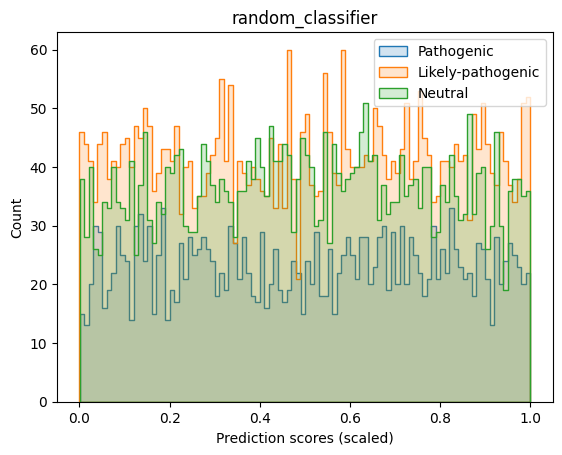

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(result_df):
    df = result_df.copy(deep=True)
    plt.cla()

    patho = result_df[result_df["class"]=="Pathogenic"]
    likely_patho = result_df[result_df["class"]=="Likely-pathogenic"]
    neutral = result_df[result_df["class"]=="Neutral"]

    bins = 100 # 20, 100, 500
    # plt.hist(knock_out["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Knock-out")
    # plt.hist(no_effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"No-effect")
    # plt.hist(effect["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Effect")
    
    sns.histplot(patho["pred"], bins=bins, label=f"Pathogenic", element="step", alpha=.2)
    sns.histplot(likely_patho["pred"], bins=bins, label=f"Likely-pathogenic", element="step", alpha=.2)
    sns.histplot(neutral["pred"], bins=bins, label=f"Neutral", element="step", alpha=.2)
    
    plt.title(f"{model_name}")
    plt.legend()
    plt.xlabel("Prediction scores (scaled)")
    plt.ylabel("Count")
    # plt.show()
    plt.savefig(home_dir+f"models/aa_common/pred_scores_distribution_plots_pathogenicity_analysis/{model_name}.png", dpi=300, format="png", bbox_inches='tight', pad_inches=0.0)


for i, (model_root, model_name) in enumerate(model_root_and_name_tuple_list):
    # model_name = "esm2_t33_650M_UR50D"
    print(model_name)
    model_pred_col = model_name + "_pred"
    if model_name=="random_classifier": 
        result_df[model_pred_col] = [random.uniform(0,1) for i in range(result_df.shape[0])]

    result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

    non_nan_result_df, _ = get_non_nan_df(result_df, model_pred_col)
        
    if model_name in models_smaller_means_damaging:
        non_nan_result_df['pred'] = non_nan_result_df['pred'].multiply(-1)

    plot_distribution(non_nan_result_df)
    # break

### For debugging purpose only

	AUC-ROC: 0.177
	AUC-PR: 0.808
(8302,)
	Best F1-Score: 0.769 at threshold: -0.508
	AUC-PR: 0.502
	Best F1-Score: 0.667 at threshold: 0.001


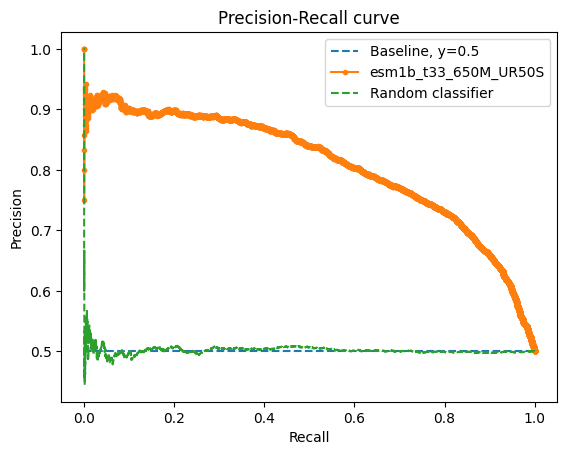

In [7]:
result_df = list_of_resut_df[0]
model_name = "esm1b_t33_650M_UR50S" # polyphen2_HVAR, esm1b_t33_650M_UR50S
model_pred_col = model_name + "_pred"

result_df["pred"]=(result_df[model_pred_col]-result_df[model_pred_col].min())/(result_df[model_pred_col].max()-result_df[model_pred_col].min()) # scaling prediction scores between [0, 1]

non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values

if model_name in models_smaller_means_damaging:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
if not larger_means_positive_class:
    non_nan_result_df["pred"] = non_nan_result_df["pred"] * (-1)

auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
print(thresholds.shape)
f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)

# f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th_(non_nan_result_df)

# print(thresholds.shape)
# print(precisions)
# print(recalls)

import matplotlib.pyplot as plt
plt.plot([0,1], [.5, .5], linestyle='--', label='Baseline, y=0.5')# precisions_list.append(p)
plt.plot(recalls, precisions, marker='.', label=f'{model_name}')


import random
result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
non_nan_result_df = result_df[~pd.isna(result_df[model_pred_col])]  # taking df for only non-NAN values
auc_pr_score, p, r, t = get_auc_pr_score(non_nan_result_df)
f1_max, th_max, p, r, t = get_f1max_and_th(p, r, t)
plt.plot(r, p, linestyle='--', label="Random classifier")


plt.ylabel("Precision")
plt.xlabel("Recall")
plt.legend()
plt.title("Precision-Recall curve")
plt.show()


# pathogenicity = result_df[result_df["class"]==task]
# neutral = result_df[result_df["class"]=="neutral"]

# bins = 100 # 20, 100, 500
# plt.hist(pathogenicity["pred"], bins=bins, density=False, log=False, alpha=.6, label=f"Pathogenicity-{model_name}")
# plt.hist(neutral["pred"], bins=bins, density=False, log=False, alpha=.4, label=f"Neutral-{model_name}")

# plt.legend()
# plt.show()

In [14]:
import random

model_name = "random_classifier"
auc_roc_score_list, auc_pr_score_list, f1_max_list, th_max_list, precision_list, recall_list, accuracy_list, balanced_accuracy_list, mcc_list = [], [], [], [], [], [], [], [], []

for i in range(10):
    result_df["pred"] = [random.uniform(0, 1) for i in range(result_df.shape[0])]
    non_nan_result_df = result_df
        
    auc_roc_score, larger_means_positive_class = get_auc_roc_score(non_nan_result_df)
    auc_pr_score, precisions, recalls, thresholds = get_auc_pr_score(non_nan_result_df)
    f1_max, th_max, precisions, recalls, thresholds = get_f1max_and_th(precisions, recalls, thresholds)
    precision = get_precision_score(non_nan_result_df, th_max)
    recall = get_recall_score(non_nan_result_df, th_max)
    accuracy = get_accuracy_score(non_nan_result_df, th_max)
    balanced_accuracy = get_balanced_accuracy_score(non_nan_result_df, th_max)
    mcc = get_matthews_corrcoef(non_nan_result_df, th_max)

    auc_roc_score_list.append(auc_roc_score)
    auc_pr_score_list.append(auc_pr_score)
    f1_max_list.append(f1_max)
    th_max_list.append(th_max)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    balanced_accuracy_list.append(balanced_accuracy)
    mcc_list.append(mcc)
    

permformance_scores = [np.mean(auc_roc_score_list), np.mean(auc_pr_score_list), np.mean(f1_max_list), 
                       np.mean(th_max_list), np.mean(precision_list), np.mean(recall_list), 
                       np.mean(accuracy_list), np.mean(balanced_accuracy_list), np.mean(mcc_list), 0.0]

output_file = home_dir+f"models/aa_common/performance_analysis/{task}_analysis/avg.csv"    
# output_file = home_dir+f"models/aa_common/performance_analysis/{task}.csv"
out = open(output_file, 'a')

out.write(f"{model_name}")
for score in permformance_scores:
    out.write(f"\t{score:.3f}")
out.write("\n")
out.close()

	AUC-ROC: 0.506
	AUC-PR: 0.513
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.500 at threshold: 0.001
	Balanced accuracy score: 0.500 at threshold: 0.001
	MCC score: 0.000 at threshold: 0.001
	AUC-ROC: 0.495
	AUC-PR: 0.497
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.026 at threshold: 0.001
	AUC-ROC: 0.502
	AUC-PR: 0.508
	Best F1-Score: 0.667 at threshold: 0.001
	Precision score: 0.500 at threshold: 0.001
	Recall score: 1.000 at threshold: 0.001
	Accuracy score: 0.501 at threshold: 0.001
	Balanced accuracy score: 0.501 at threshold: 0.001
	MCC score: 0.026 at threshold: 0.001
	AUC-ROC: 0.508
	AUC-PR: 0.506
	Best F1-Score: 0.667 at threshold: 0.000
	Precision score: 0.500 at threshold: 0.000
	Recall sc